In [1]:
#This code includes only option set data from 2020 to 2023
import pandas as pd
import glob 
import copy
import numpy as np
import matplotlib.pyplot as plt
import datetime
import sklearn.linear_model

import seaborn as sns
import lightgbm as lgb

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from plotly.graph_objs import Surface
from plotly.offline import iplot, init_notebook_mode

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pandas import DataFrame

In [2]:
#Data set for files from 01/2020 to 03/2023
FileSet = glob.glob("C:/Users/dsirivolu/Documents/BootCamp/Project/DATA/Data*.csv")

In [3]:
list_df = []

for csvfile in FileSet:
    df = pd.read_csv(csvfile)
    list_df.append(df)    
    
optionset_df = pd.concat(list_df, axis = 0, ignore_index=True)

In [4]:
test_columns = ["date", "exdate", "last_date", "cp_flag", "strike_price", "best_bid", "best_offer",
                 "volume", "open_interest", "impl_volatility", "delta", "gamma", "vega", "theta"]

spx_optionset_df = optionset_df[test_columns]

In [5]:
spx_optionset_df.shape

(14988229, 14)

In [6]:
#Merging additional values with option set from 2020 to 2023
spx_optionset_df["date"] = pd.to_datetime(spx_optionset_df["date"])

C:\Users\dsirivolu\AppData\Local\Temp\ipykernel_1956\2874709516.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [7]:
spx_optionset_df.head()

,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta
0,2020-01-02,2020-02-21,NaN,C,1775000,1472.8,1482.4,0,0,NaN,NaN,NaN,NaN,NaN
1,2020-01-02,2020-02-21,NaN,C,1800000,1447.8,1457.5,0,0,NaN,NaN,NaN,NaN,NaN
2,2020-01-02,2020-02-21,NaN,C,1825000,1422.9,1432.5,0,0,NaN,NaN,NaN,NaN,NaN
3,2020-01-02,2020-02-21,NaN,C,1850000,1398.0,1407.6,0,0,NaN,NaN,NaN,NaN,NaN
4,2020-01-02,2020-02-21,NaN,C,1875000,1373.1,1382.7,0,0,NaN,NaN,NaN,NaN,NaN


In [9]:
#Removing NaN values
spx_optionset_df = spx_optionset_df.dropna()

In [10]:
spx_optionset_df.shape

(10275356, 14)

In [11]:
#Creating variables midprice and stock_price, moneyness, time_to_expiry.
#mid_price: is the average of best_bid and best_offer.
spx_optionset_df["mid_price"] = (spx_optionset_df["best_bid"]+spx_optionset_df["best_offer"])/2

#Converting dates to datetime format.
spx_optionset_df["date"] = pd.to_datetime(spx_optionset_df["date"])
spx_optionset_df["exdate"] = pd.to_datetime(spx_optionset_df["exdate"])
spx_optionset_df["last_date"] = pd.to_datetime(spx_optionset_df["last_date"])

spx_optionset_df["time_to_expiry"] = spx_optionset_df["exdate"] - spx_optionset_df["date"]
spx_optionset_df['time_to_expiry'] = spx_optionset_df['time_to_expiry']/pd.to_timedelta(1, unit = 'D')

In [12]:
spx_optionset_df.shape

(10275356, 16)

In [14]:
spx_optionset_df.head()

,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,mid_price,time_to_expiry
52,2020-01-02,2020-02-21,2020-01-02,P,3305000,73.0,73.5,4,32,0.096145,-0.650058,0.003214,440.3356,-156.0301,73.25,50.0
57,2020-01-02,2020-02-21,2019-12-30,P,3310000,75.8,76.4,0,16,0.094980,-0.667829,0.003189,431.5555,-150.9527,76.10,50.0
58,2020-01-02,2020-02-21,2020-01-02,P,3315000,78.8,79.4,60,15,0.093939,-0.685383,0.003152,421.8588,-145.8238,79.10,50.0
70,2020-01-02,2020-02-21,2020-01-02,P,3320000,82.0,82.5,30,0,0.093029,-0.702598,0.003103,411.3378,-140.6833,82.25,50.0
71,2020-01-02,2020-02-21,2020-01-02,P,3325000,85.2,85.8,3,406,0.092135,-0.719631,0.003046,399.9182,-135.3279,85.50,50.0


In [15]:
#Divide strike prices by 1000 to match with the correct prices of spx.
spx_optionset_df["strike_price"] = spx_optionset_df["strike_price"]/1000

In [16]:
spx_optionset_df.head()

,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,mid_price,time_to_expiry
52,2020-01-02,2020-02-21,2020-01-02,P,3305.0,73.0,73.5,4,32,0.096145,-0.650058,0.003214,440.3356,-156.0301,73.25,50.0
57,2020-01-02,2020-02-21,2019-12-30,P,3310.0,75.8,76.4,0,16,0.094980,-0.667829,0.003189,431.5555,-150.9527,76.10,50.0
58,2020-01-02,2020-02-21,2020-01-02,P,3315.0,78.8,79.4,60,15,0.093939,-0.685383,0.003152,421.8588,-145.8238,79.10,50.0
70,2020-01-02,2020-02-21,2020-01-02,P,3320.0,82.0,82.5,30,0,0.093029,-0.702598,0.003103,411.3378,-140.6833,82.25,50.0
71,2020-01-02,2020-02-21,2020-01-02,P,3325.0,85.2,85.8,3,406,0.092135,-0.719631,0.003046,399.9182,-135.3279,85.50,50.0


In [17]:
spx_optionset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10275356 entries, 52 to 14988228
Data columns (total 16 columns):
 #   Column           Dtype         
---  ------           -----         
 0   date             datetime64[ns]
 1   exdate           datetime64[ns]
 2   last_date        datetime64[ns]
 3   cp_flag          object        
 4   strike_price     object        
 5   best_bid         float64       
 6   best_offer       float64       
 7   volume           object        
 8   open_interest    object        
 9   impl_volatility  float64       
 10  delta            float64       
 11  gamma            float64       
 12  vega             float64       
 13  theta            float64       
 14  mid_price        float64       
 15  time_to_expiry   float64       
dtypes: datetime64[ns](3), float64(9), object(4)
memory usage: 1.3+ GB


In [18]:
#Changing strike price to float
spx_optionset_df['strike_price'] = pd.to_numeric(spx_optionset_df['strike_price']).astype(float)

In [19]:
spx_optionset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10275356 entries, 52 to 14988228
Data columns (total 16 columns):
 #   Column           Dtype         
---  ------           -----         
 0   date             datetime64[ns]
 1   exdate           datetime64[ns]
 2   last_date        datetime64[ns]
 3   cp_flag          object        
 4   strike_price     float64       
 5   best_bid         float64       
 6   best_offer       float64       
 7   volume           object        
 8   open_interest    object        
 9   impl_volatility  float64       
 10  delta            float64       
 11  gamma            float64       
 12  vega             float64       
 13  theta            float64       
 14  mid_price        float64       
 15  time_to_expiry   float64       
dtypes: datetime64[ns](3), float64(10), object(3)
memory usage: 1.3+ GB


In [20]:
#Define model 1 for positive delta values and call options

threshold_value = 0.0

Model1_For_Call_df = spx_optionset_df[(spx_optionset_df['delta'] > threshold_value) & (spx_optionset_df['cp_flag'] == 'C')]

In [21]:
Model1_For_Call_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4518549 entries, 135 to 14988130
Data columns (total 16 columns):
 #   Column           Dtype         
---  ------           -----         
 0   date             datetime64[ns]
 1   exdate           datetime64[ns]
 2   last_date        datetime64[ns]
 3   cp_flag          object        
 4   strike_price     float64       
 5   best_bid         float64       
 6   best_offer       float64       
 7   volume           object        
 8   open_interest    object        
 9   impl_volatility  float64       
 10  delta            float64       
 11  gamma            float64       
 12  vega             float64       
 13  theta            float64       
 14  mid_price        float64       
 15  time_to_expiry   float64       
dtypes: datetime64[ns](3), float64(10), object(3)
memory usage: 586.1+ MB


In [22]:
correlation_matrix = Model1_For_Call_df[["impl_volatility", "delta", "gamma", "vega", "theta", "strike_price", "mid_price", "time_to_expiry"]].corr()

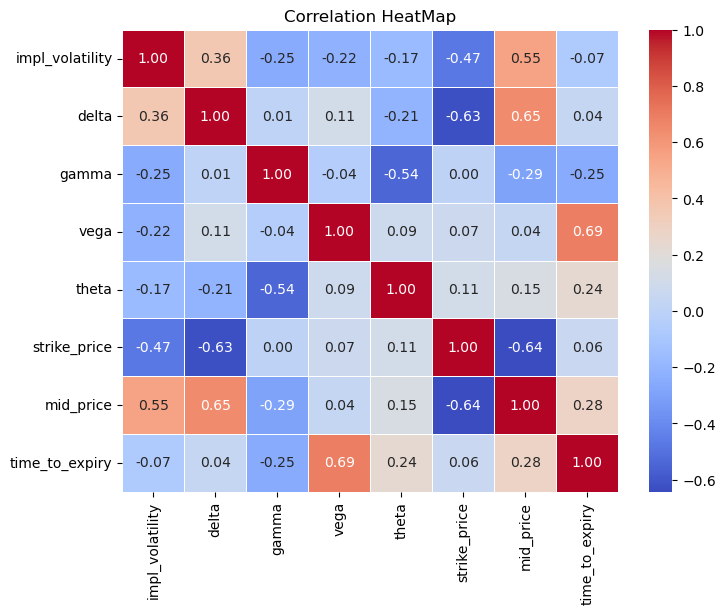

In [23]:
plt.figure(figsize = (8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation HeatMap')
plt.show()

In [24]:
#Training the model for positive delta & call options

x1 = Model1_For_Call_df[['delta', 'gamma', 'vega', 'theta', 'strike_price', 'mid_price', 'time_to_expiry']]
y1 = Model1_For_Call_df['impl_volatility']

print("The shape of x is:", x1.shape)
print("The shape of y is:", y1.shape)

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.2)

print("The shape of x_train is:", x1_train.shape)
print("The shape of y_train is:", y1_train.shape)

print("The shape of x_test is:", x1_test.shape)
print("The shape of y_test is:", y1_test.shape)

The shape of x is: (4518549, 7)
The shape of y is: (4518549,)
The shape of x_train is: (3614839, 7)
The shape of y_train is: (3614839,)
The shape of x_test is: (903710, 7)
The shape of y_test is: (903710,)


In [25]:
#Parameter setting
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 8,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [26]:
# laoding data
model1_call_train = lgb.Dataset(x1_train, y1_train)
model1_call_eval = lgb.Dataset(x1_test, y1_test, reference=model1_call_train)

model1_call = lgb.train(params,
                  train_set=model1_call_train,
                  valid_sets=model1_call_eval)

In [27]:
# prediction
y1_pred = model1_call.predict(x1_test)

In [28]:
# accuracy check
mse = mean_squared_error(y1_test, y1_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse) 

MSE: 0.00
RMSE: 0.06


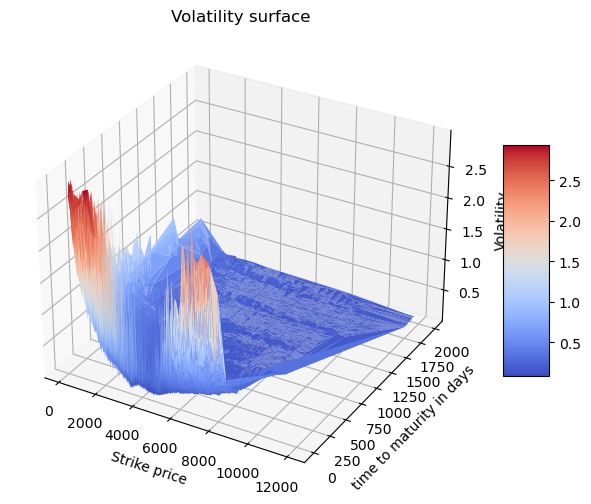

In [29]:
fig = plt.figure(figsize = (8,6))
ax = plt.axes(projection = '3d')

surf = ax.plot_trisurf(x1_test['strike_price'], x1_test['time_to_expiry'], y1_test, cmap = cm.coolwarm)

ax.set_title('Volatility surface')

ax.set_xlabel('Strike price')
ax.set_ylabel('time to maturity in days')
ax.set_zlabel('Volatility');

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [30]:
#Define model 2 for negative delta values and put options

threshold_value = 0.0

Model2_For_Put_df = spx_optionset_df[(spx_optionset_df['delta'] < threshold_value) & (spx_optionset_df['cp_flag'] == 'P')]

In [31]:
Model2_For_Put_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5756807 entries, 52 to 14988228
Data columns (total 16 columns):
 #   Column           Dtype         
---  ------           -----         
 0   date             datetime64[ns]
 1   exdate           datetime64[ns]
 2   last_date        datetime64[ns]
 3   cp_flag          object        
 4   strike_price     float64       
 5   best_bid         float64       
 6   best_offer       float64       
 7   volume           object        
 8   open_interest    object        
 9   impl_volatility  float64       
 10  delta            float64       
 11  gamma            float64       
 12  vega             float64       
 13  theta            float64       
 14  mid_price        float64       
 15  time_to_expiry   float64       
dtypes: datetime64[ns](3), float64(10), object(3)
memory usage: 746.7+ MB


In [32]:
correlation_matrix2 = Model2_For_Put_df[["impl_volatility", "delta", "gamma", "vega", "theta", "strike_price", "mid_price", "time_to_expiry"]].corr()

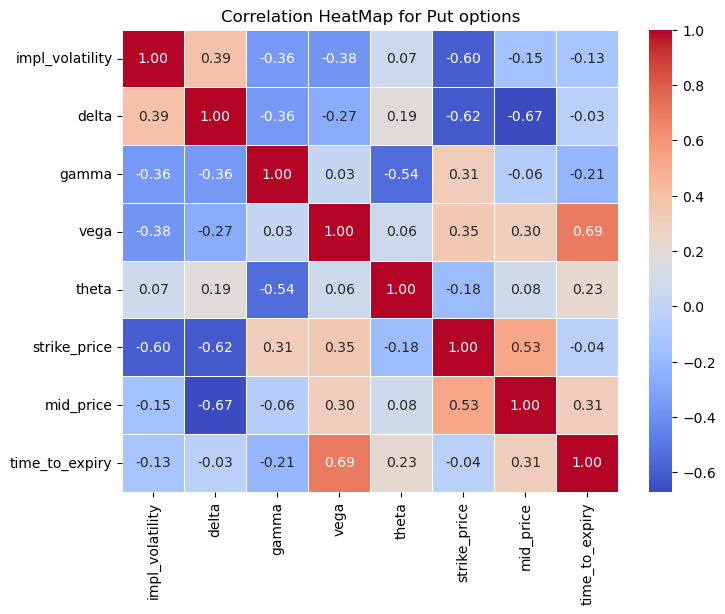

In [33]:
plt.figure(figsize = (8,6))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation HeatMap for Put options')
plt.show()

In [34]:
#Training the model for negative delta values & Put options

x2 = Model2_For_Put_df[['delta', 'gamma', 'vega', 'theta', 'strike_price', 'mid_price', 'time_to_expiry']]
y2 = Model2_For_Put_df['impl_volatility']

print("The shape of x is:", x2.shape)
print("The shape of y is:", y2.shape)

x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size = 0.2)

print("The shape of x_train is:", x2_train.shape)
print("The shape of y_train is:", y2_train.shape)

print("The shape of x_test is:", x2_test.shape)
print("The shape of y_test is:", y2_test.shape)

The shape of x is: (5756807, 7)
The shape of y is: (5756807,)
The shape of x_train is: (4605445, 7)
The shape of y_train is: (4605445,)
The shape of x_test is: (1151362, 7)
The shape of y_test is: (1151362,)


In [35]:
#Parameter setting
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 8,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [36]:
# laoding data
model2_put_train = lgb.Dataset(x2_train, y2_train)
model2_put_eval = lgb.Dataset(x2_test, y2_test, reference=model2_put_train)

model2_put = lgb.train(params,
                  train_set=model2_put_train,
                  valid_sets=model2_put_eval)

In [37]:
# prediction
y2_pred = model2_put.predict(x2_test)

In [43]:
# accuracy check

mse = mean_squared_error(y2_test, y2_pred)
rmse = mse**(0.5)

print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse) 

MSE: 0.00
RMSE: 0.06


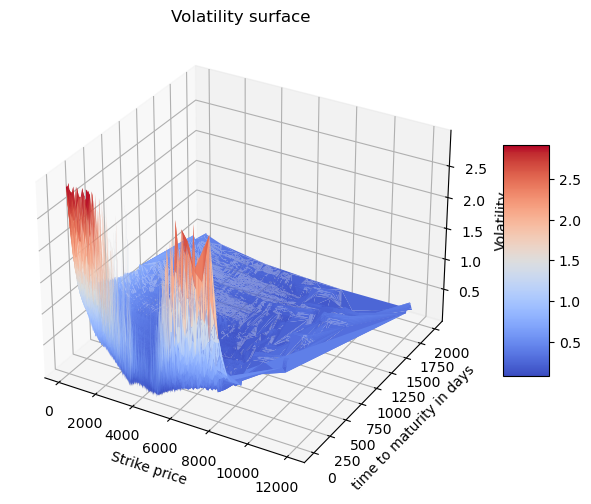

In [39]:
fig = plt.figure(figsize = (8,6))
ax = plt.axes(projection = '3d')

surf = ax.plot_trisurf(x2_test['strike_price'], x2_test['time_to_expiry'], y2_test, cmap = cm.coolwarm)

ax.set_title('Volatility surface')

ax.set_xlabel('Strike price')
ax.set_ylabel('time to maturity in days')
ax.set_zlabel('Volatility');

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

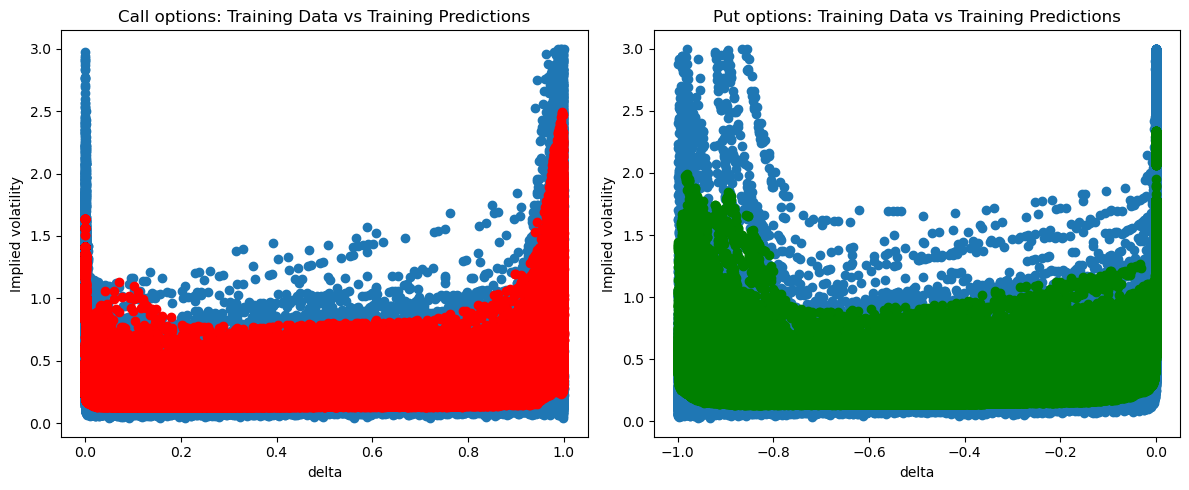

In [45]:
#Plotting the test data and predictions for call options and put options
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

#Test data and predictions for call options
axes[0].scatter(x1_test['delta'], y1_test, label='Training Data')
axes[0].scatter(x1_test['delta'], y1_pred, color='r', label='Training Prediction')
axes[0].set_xlabel('delta')
axes[0].set_ylabel('Implied volatility')
axes[0].set_title('Call options: Training Data vs Training Predictions')

#Test data and predictions for put options
axes[1].scatter(x2_test['delta'], y2_test, label='Training Data')
axes[1].scatter(x2_test['delta'], y2_pred, color='g', label='Training Prediction')
axes[1].set_xlabel('delta')
axes[1].set_ylabel('Implied volatility')
axes[1].set_title('Put options: Training Data vs Training Predictions')

plt.tight_layout()
plt.show()